# Encoder Decoder model with Global Attention Mechanism

### connecting to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Installing packages

In [ ]:
import gdown
import tarfile
import warnings
from tqdm import tqdm
import pickle
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add, MaxPooling2D, GRU, AveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [ ]:
image_dataset_path = "https://drive.google.com/uc?export=download&id=1ZyPCD6T3EAKcEiBX4c-PNEGOAGS7jrAT"
image_dataset_output = 'NLMCXR_png.tgz'
gdown.download(image_dataset_path, image_dataset_output, quiet=False)
train_pickle_dataset_path = "https://drive.google.com/uc?export=download&id=10SVBKA44M6h0-XingbqjEdCOuy8ml35z"
train_pickle_dataset_output = 'train.pkl'
gdown.download(train_pickle_dataset_path, train_pickle_dataset_output, quiet=False)
test_pickle_dataset_path = "https://drive.google.com/uc?export=download&id=10R5___WNWTmko4igE_gmXaPq8i6vhHzG"
test_pickle_dataset_output = 'test.pkl'
gdown.download(test_pickle_dataset_path, test_pickle_dataset_output, quiet=False)
chexnet_weights_path = "https://drive.google.com/uc?export=download&id=1lpLnjZEsoIAfLfvfOsVgQId6qDDEYHZ0"
chexnet_weights_output = 'chexnet.h5'
gdown.download(chexnet_weights_path, chexnet_weights_output, quiet=False)
images = tarfile.open('NLMCXR_png.tgz')
images.extractall(os.getcwd()+'/images/')

Downloading...
From: https://drive.google.com/uc?export=download&id=1ZyPCD6T3EAKcEiBX4c-PNEGOAGS7jrAT
To: /content/NLMCXR_png.tgz
100%|██████████| 1.36G/1.36G [00:06<00:00, 204MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=10SVBKA44M6h0-XingbqjEdCOuy8ml35z
To: /content/train.pkl
100%|██████████| 2.67M/2.67M [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=10R5___WNWTmko4igE_gmXaPq8i6vhHzG
To: /content/test.pkl
100%|██████████| 608k/608k [00:00<00:00, 57.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1lpLnjZEsoIAfLfvfOsVgQId6qDDEYHZ0
To: /content/chexnet.h5
100%|██████████| 29.1M/29.1M [00:00<00:00, 234MB/s]


In [ ]:
image_folder = os.getcwd()+'/images/'
chexnet_weights = 'chexnet.h5'

In [ ]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')
train.shape,test.shape

((8795, 8), (604, 8))

In [ ]:
train.head()


,findings,patient_id,image1,image2,findings_total,decoder_ip,decoder_op,findings_count
0,the heart is normal in size. the mediastinum i...,CXR2950,/content/images/CXR2950_IM-1348-1001.png,/content/images/CXR2950_IM-1348-2001.png,<start> the heart is normal in size. the media...,<start> the heart is normal in size. the media...,the heart is normal in size. the mediastinum i...,51
1,the cardiomediastinal silhouette and pulmonary...,CXR1264,/content/images/CXR1264_IM-0179-1001.png,/content/images/CXR1264_IM-0179-2001.png,<start> the cardiomediastinal silhouette and p...,<start> the cardiomediastinal silhouette and p...,the cardiomediastinal silhouette and pulmonary...,26
2,cardiac and mediastinal contours are within no...,CXR1928,/content/images/CXR1928_IM-0600-1001.png,/content/images/CXR1928_IM-0600-2001.png,<start> cardiac and mediastinal contours are w...,<start> cardiac and mediastinal contours are w...,cardiac and mediastinal contours are within no...,35
3,heart size normal. lungs are clear. are normal...,CXR1588,/content/images/CXR1588_IM-0382-1001.png,/content/images/CXR1588_IM-0382-2001.png,<start> heart size normal. lungs are clear. ar...,<start> heart size normal. lungs are clear. ar...,heart size normal. lungs are clear. are normal...,46
4,heart size normal. lungs are clear. are normal...,CXR795,/content/images/CXR795_IM-2331-1001.png,/content/images/CXR795_IM-2331-1002.png,<start> heart size normal. lungs are clear. ar...,<start> heart size normal. lungs are clear. ar...,heart size normal. lungs are clear. are normal...,46


### Building tokeniser for findings

In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.findings_total.values)
train_captions = tokenizer.texts_to_sequences(train.findings_total) 
test_captions = tokenizer.texts_to_sequences(test.findings_total) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<start>'] #tokened value of <start>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 75 percentile value of caption_len which is %i will be taken as the maximum padded value for each findings for faster training.'
%(np.percentile(caption_len,75)))
max_pad = int(np.percentile(caption_len,75))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader


The max and min value of "caption length" was found to be 169 and 9 respectively
The 75 percentile value of caption_len which is 42 will be taken as the maximum padded value for each impression for faster training.


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp /content/tokenizer.pickle /content/drive/MyDrive/Project_on_Drive

# **Modelling**

## **Hyperparameters**

In [ ]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

## **Creating an input data pipeline**

In [ ]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and findings
    """
    self.image1 = df.image1
    self.image2 = df.image2
    self.caption = df.decoder_ip	 #inp
    self.caption1 = df.decoder_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    # self.aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    # #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    # self.aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_batch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

## **CHeXNET Model (pretrained)**

[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Denset121 layered model which is trained on 1000s of chest x-ray images for the classification of 14 diseases.We can load the weights of that model and pass the image through that model. The top layer will be ignore.

In [ ]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights,input_size = input_size):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,)) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of the chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-3].output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
  #since we are using attention here
  return chexnet

## Attention Model

References:
[attention](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)

In [ ]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

### Image Encoder Layer

In [ ]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    self.avgpool = AveragePooling2D()
    
  def call(self,data):
    op = self.chexnet(data) #op shape: (None,7,7,1024)
    op = self.avgpool(op) #op shape (None,3,3,1024)
    op = tf.reshape(op,shape = (-1,op.shape[1]*op.shape[2],op.shape[3])) #op shape: (None,9,1024)
    return op 

### Encoder

In [ ]:
def encoder(image1,image2,dense_dim = dense_dim,dropout_rate = dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Image_encoder()
  bkfeat1 = im_encoder(image1) #shape: (None,9,1024)
  bk_dense = Dense(dense_dim,name = 'bkdense',activation = 'relu') #shape: (None,9,512)
  bkfeat1 = bk_dense(bkfeat1)

  #image2
  bkfeat2 = im_encoder(image2) #shape: (None,9,1024)
  bkfeat2 = bk_dense(bkfeat2) #shape: (None,9,512)


  #combining image1 and image2
  concat = Concatenate(axis=1)([bkfeat1,bkfeat2]) #concatenating through the second axis shape: (None,18,1024)
  bn = BatchNormalization(name = "encoder_batch_norm")(concat) 
  dropout = Dropout(dropout_rate,name = "encoder_dropout")(bn)
  return dropout

Global Attention equations



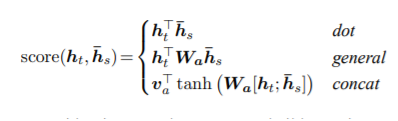


Here I will be using concat score of global attention.
[reference](https://github.com/uzaymacar/attention-mechanisms#local-attention)

### Global Attention Layer

In [ ]:
class global_attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self,dense_dim = dense_dim):
    super().__init__()
    # Intialize variables needed for Concat score function here
    self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
    self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
    self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
      #op (None,98,1)


  def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
    decoder_h = tf.expand_dims(decoder_h,axis=1) #shape: (None,1,dense_dim)
    tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
    tanh_output =  tf.nn.tanh(tanh_input)
    attention_weights = tf.nn.softmax(self.V(tanh_output),axis=1) #shape= batch_size*98*1 getting attention alphas
    op = attention_weights*encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
    context_vector = tf.reduce_sum(op,axis=1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


    return context_vector,attention_weights

In [ ]:
glove = {}
with open('/content/drive/MyDrive/Project_on_Drive/glove/glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in tqdm(f):
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tqdm(tokenizer.word_index.items()):
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

400000it [00:24, 16618.01it/s]
100%|██████████| 2111/2111 [00:00<00:00, 325892.59it/s]


### One Step Decoder

In [ ]:
class One_Step_Decoder(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim ,name = "onestepdecoder"):
    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.embedding = Embedding(input_dim = vocab_size+1,
                                output_dim = embedding_dim,
                                input_length=max_pad,
                                weights = [embedding_matrix],
                                mask_zero=True, 
                                name = 'onestepdecoder_embedding'
                              )
    self.LSTM = GRU(units=self.dense_dim,return_sequences=True,return_state=True,name = 'onestepdecoder_LSTM')
    self.LSTM1 = GRU(units=self.dense_dim,return_sequences=False,return_state=True,name = 'onestepdecoder_LSTM1')
    self.attention = global_attention(dense_dim = dense_dim)
    self.concat = Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'onestepdecoder_embedding_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.concat = Concatenate(axis=-1)
    self.add =Add()
  @tf.function
  def call(self,input_to_decoder, encoder_output, decoder_h):#,decoder_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

      here state_h,state_c are decoder states
    '''
    embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    

    context_vector,attention_weights = self.attention(encoder_output,decoder_h) #passing hidden state h of decoder and encoder output
    #context_vector shape: batch_size*dense_dim we need to add time dimension
    context_vector_time_axis = tf.expand_dims(context_vector,axis=1)
    #now we will combine attention output context vector with next word input to the lstm here we will be teacher forcing
    concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
    output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
    output,decoder_h = self.LSTM1(output,initial_state = decoder_h)
    #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
    #we need to remove the time axis from this decoder_output
    

    output = self.final(output)#shape = batch_size*decoder vocab size
    return output,decoder_h,attention_weights

### Decoder

In [ ]:
class decoder(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad = max_pad, embedding_dim = embedding_dim,dense_dim = dense_dim,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.output_array = tf.TensorArray(tf.float32,size=max_pad)
    self.max_pad = max_pad
    self.batch_size = batch_size
    self.dense_dim =dense_dim
    
  @tf.function
  def call(self,encoder_output,caption):#,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
    decoder_h, decoder_c = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0]) #decoder_h, decoder_c
    output_array = tf.TensorArray(tf.float32,size=max_pad)
    for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
      output,decoder_h,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
      output_array = output_array.write(timestep,output) #timestep*batch_size*vocab_size

    self.output_array = tf.transpose(output_array.stack(),[1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
    return self.output_array

### Global Attention Model

In [ ]:
#model creation
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))

encoder_output = encoder(image1,image2) #shape: (None,28,512)

output = decoder()(encoder_output,caption)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_encoder (Image_encoder)  (None, 9, 1024)      7037504     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

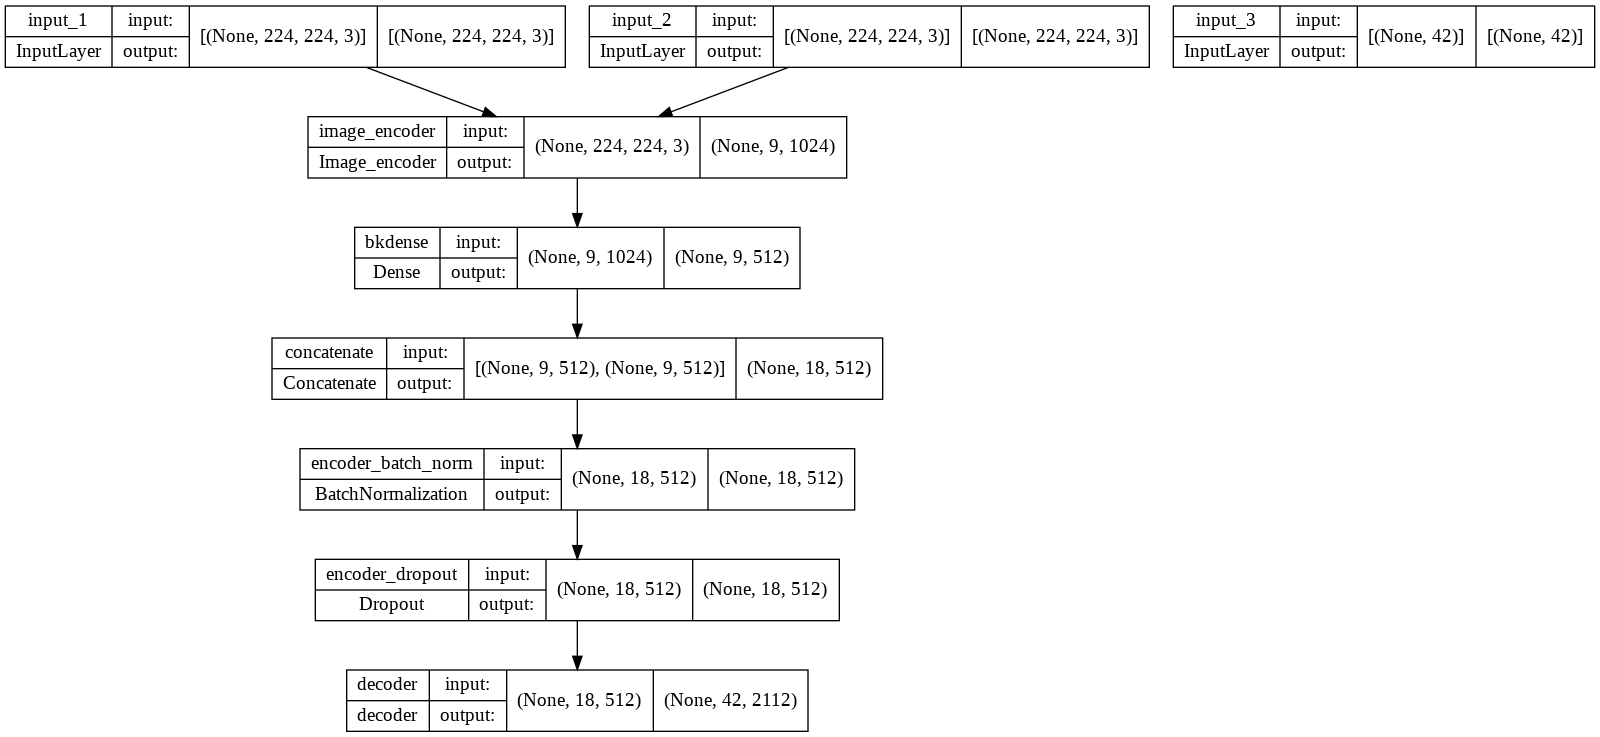

In [ ]:
tf.keras.utils.plot_model(model,to_file='encoder_decoder_with_attention.png',show_shapes = True )


In [ ]:
!cp encoder_decoder_with_attention.png /content/drive/MyDrive/Project_on_Drive

In [ ]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-2
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [ ]:
tf.keras.backend.clear_session()
tb_filename = 'Encoder_Decoder_global_attention/'
tb_file = os.path.join('/content/drive/MyDrive/Project_on_Drive',tb_filename)
model_filename = 'Encoder_Decoder_global_attention.h5'
model_save = os.path.join('/content/drive/MyDrive/Project_on_Drive',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [ ]:
!rm -r '/content/drive/MyDrive/Project_on_Drive/Encoder_Decoder_global_attention/'

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 3.3515 - accuracy: 0.4966
Epoch 1: val_loss improved from inf to 2.81636, saving model to /content/drive/MyDrive/Project_on_Drive/Encoder_Decoder_global_attention.h5
87/87 [==============================] - 239s 2s/step - loss: 3.3515 - accuracy: 0.4966 - val_loss: 2.8164 - val_accuracy: 0.5714 - lr: 0.0100
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 2.3061 - accuracy: 0.6394
Epoch 2: val_loss improved from 2.81636 to 2.29714, saving model to /content/drive/MyDrive/Project_on_Drive/Encoder_Decoder_global_attention.h5
87/87 [==============================] - 173s 2s/step - loss: 2.3061 - accuracy: 0.6394 - val_loss: 2.2971 - val_accuracy: 0.6508 - lr: 0.0100
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 1.8525 - accuracy: 0.6887
Epoch 3: val_loss improved from 2.29714 to 1.99100, saving model to /content/drive/MyDrive/Project_on_Drive/Encoder_Decoder_global_attention.h5
87/8

### Tensorboard

In [ ]:
model_filename = "Encoder_Decoder_global_attention.h5"
model_save = os.path.join('/content/drive/MyDrive/Project_on_Drive/',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Project_on_Drive/Encoder_Decoder_global_attention/'

## Predictions

### Bleu score function

We will compute bleu scores 1-gram,2-gram, 3-gram and 4-gram for each sentence.

In [ ]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0))
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [ ]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the findings of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in tqdm(test.iterrows()):
    if top_k==None:
      predict_val = predict(data['image1'],data['image2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image1'],data['image2'],model = model,top_k = top_k)
    true = data.findings
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

### **Greedy Search**

In [ ]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the findings part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  image1 = model.get_layer('image_encoder')(image1)
  image2 = model.get_layer('image_encoder')(image2)
  image1 = model.get_layer('bkdense')(image1)
  image2 = model.get_layer('bkdense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  enc_op = model.get_layer('encoder_batch_norm')(concat)  
  enc_op = model.get_layer('encoder_dropout')(enc_op) #this is the output from encoder


  decoder_h,decoder_c = tf.zeros_like(enc_op[:,0]),tf.zeros_like(enc_op[:,0])
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<start>'])) #shape: (1,1)
    output,decoder_h,attention_weights = model.get_layer('decoder').onestepdecoder(caption,enc_op,decoder_h)#,decoder_c) decoder_c,

    #prediction
    max_prob = tf.argmax(output,axis=-1)  #tf.Tensor of shape = (1,1)
    caption = np.array([max_prob]) #will be sent to onstepdecoder for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [ ]:
%%time
k = 200
image1,image2 = test.image1.iloc[k],test.image2.iloc[k]
print(greedy_search_predict(image1,image2,model1))

the cardiomediastinal silhouette is within normal limits for appearance. no focal areas of pulmonary consolidation. no pneumothora. no pleural effusion. the thoracic spine appears intact.
CPU times: user 4.1 s, sys: 1.1 s, total: 5.2 s
Wall time: 13 s


In [ ]:
%%time
mean_bleu_predict = mean_bleu(test,greedy_search_predict)

604it [04:39,  2.16it/s]

CPU times: user 4min 56s, sys: 12 s, total: 5min 8s
Wall time: 4min 39s


In [ ]:
k = list(mean_bleu_predict)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.283326,0.166389,0.099237,0.053017


# **Inference**

Now we will predict all datapoints with best approach chosen (here it is greedy search) and see the results manually and also compute bleu (1 gram) score.

In [ ]:
%%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search

for index,rows in tqdm(test.iterrows()):
  #greedy search
  predicted_text = greedy_search_predict(rows.image1,rows.image2,model1)
  test.loc[index,'prediction_gs'] = predicted_text
  reference = [rows['findings'].split()]
  test.loc[index,'bleu_1_gs'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

604it [04:12,  2.40it/s]

CPU times: user 4min 25s, sys: 8.88 s, total: 4min 33s
Wall time: 4min 12s


In [ ]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search

From the above results, the model is predicting captions with lot of variations. It is doing far better than the baseline model where it was predicting 80% of the test data with the same caption even though we did upsampling and downsampling of the data.

## Random predictions on test data

In [ ]:
def final_caption_pred(image1,image2,method = "beam",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the modelreturns the predicted caption
  method: "greedy" or "g" for greedy search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  else:
    print("'g' or 'greedy' for greedy search")
  return pred_caption

In [ ]:
def inference(image1,image2,true_caption,model=model1,image_size = (10,20)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))


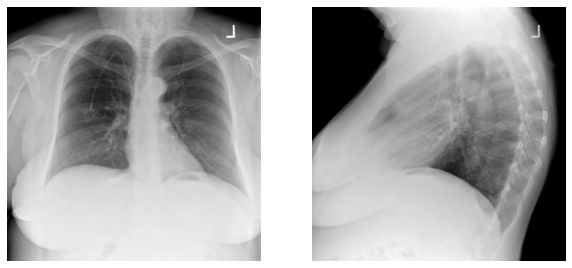


True caption: 'heart size, mediastinal contour, and pulmonary vascularity are within normal limits. there is a right chest with central venous catheter tip overlying the high svc. no focal consolidation, suspicious pulmonary opacity, large pleural effusion, or pneumothora is identified. visualized osseous structures appear intact.'
Predicted caption(greedy search): 'the lungs are clear. there is no pleural effusion or pneumothora. the heart and mediastinum are normal. the skeletal structures are normal.'


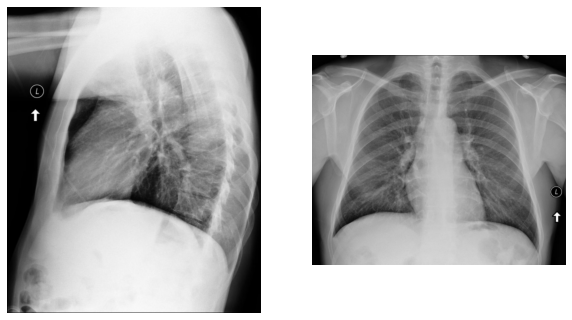


True caption: 'no pneumothora. heart size is normal. no large pleural effusions. no focal airspace consolidation.'
Predicted caption(greedy search): 'the lungs are clear. there is no pleural effusion or pneumothora. the heart and mediastinum are normal. the skeletal structures are normal. surgical clips are present in the right upper quadrant.'


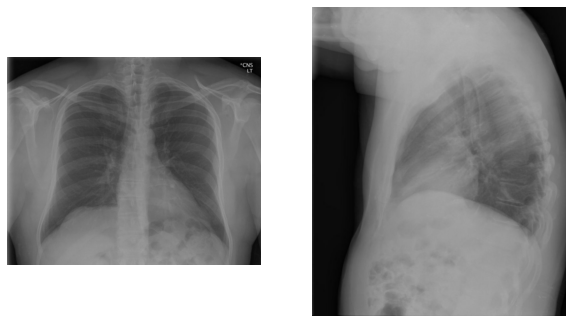


True caption: 'calcified left lower lobe granuloma. no focal areas of consolidation. no pleural effusions. no pneumothora. degenerative changes noted of the thoracic spine.'
Predicted caption(greedy search): 'the lungs are clear. there is no pleural effusion or pneumothora. the heart and mediastinum are normal. the skeletal structures are normal.'


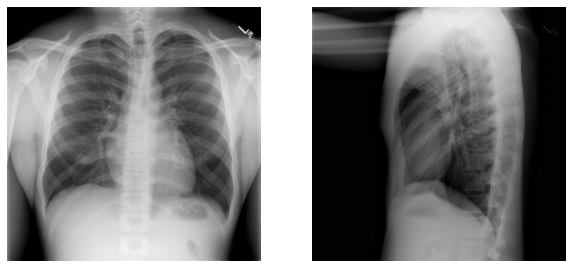


True caption: 'heart size is normal. no focal airspace consolidations. no pneumothora or pleural effusion. no acute osseous findings.'
Predicted caption(greedy search): 'the lungs are clear. there is no pleural effusion or pneumothora. the heart and mediastinum are normal. the skeletal structures are normal. surgical clips are present in the right upper quadrant.'


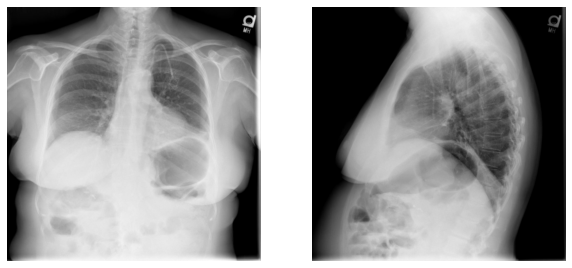


True caption: 'low lung volumes are present. the heart size and pulmonary vascularity appear within normal limits. no pleural effusion or pneumothora is seen. scattered of left base atelectasis are noted. left -a- is in with the tip projecting over the caval atrial junction.'
Predicted caption(greedy search): 'the cardiomediastinal silhouette is within normal limits for appearance. no focal areas of pulmonary consolidation. no pneumothora. no pleural effusion. the thoracic spine appears intact.'


In [ ]:
i = test['bleu_1_gs'].sample(5).index
for k in i:
  image1,image2 = test['image1'][k],test['image2'][k]
  true_caption = test['findings'][k]
  inference(image1,image2,true_caption)

# Conclusion

In [ ]:
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.283326,0.166389,0.099237,0.053017


This model performed better than simple baseline model since it produced captions which had higher variablity and also remained lingusitically similiar. Even then we can see that most of datapoints were of normal chest or no disease category we need to collect more dataset which have x-rays of patients having diseases so that to improve the model's performance. Even the model predicted tough captions which had similiar meaning to the true ones.
